In [2]:
import seaborn as sns

custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 1.25,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif"}
sns.set_theme(context = "poster", style="ticks", rc=custom_params) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression 
from pathlib import Path
import pandas as pd
from pathlib import Path
import re


class MSDcalculator_saver:
    def __init__(self, pickle_path, save_dir="./Results/test/", new_timestep=0.01):
        self.new_timestep = new_timestep
        self.fs = round(1 / new_timestep)
        self._load_pickle(pickle_path)
        self._resample_data()
        self.save_dir = Path(save_dir) / Path(pickle_path).stem
        self.T = self.extract_T(str(pickle_path))
        print(self.T)

    def _load_pickle(self, path):
        with open(path, "rb") as f:
            data = pickle.load(f)

        self.raw_data = data
        self.tau = data["tau"]
        self.num_trajectories = data["N_trajectories"]

        self.x_all = [np.array(data[f"x_{i}"]) for i in range(self.num_trajectories)]
        self.y_all = [np.array(data[f"y_{i}"]) for i in range(self.num_trajectories)]
        self.phi_all = [
            np.array(data.get(f"phi_{i}", np.zeros_like(self.x_all[i])))
            for i in range(self.num_trajectories)
        ]
        self.t = np.array(data["t"])

    @staticmethod
    def extract_T(name):
        match = re.search(r"(?<!kb)T_([0-9.eE+-]+)", str(name))
        return float(match.group(1).rstrip('-')) if match else None

    def _resample_data(self):
        idx_step = round(self.new_timestep / self.tau)
        self.fs = round(1 / self.new_timestep)
        self.t = self.t[::idx_step]

        self.x_all = [x[::idx_step] for x in self.x_all]
        self.y_all = [y[::idx_step] for y in self.y_all]
        self.phi_all = [phi[::idx_step] for phi in self.phi_all]

    def compute_increments(self, signal):
        max_scale = int(np.floor(np.log10(len(signal))))
        intermediate = [0.1 * n for n in range(1, 10 * max_scale)]
        scales = np.unique(np.floor([10**n for n in intermediate])).astype(int)

        increments = np.full((len(scales), len(signal)), np.nan)
        for i, scale in enumerate(scales):
            inc = signal[scale:] - signal[:-scale]
            increments[i, :len(inc)] = inc

        return [s / self.fs for s in scales], increments, scales

    def _sin_func(self, x, amplitude, freq, phase, offset):
        return offset + amplitude * np.sin(2 * np.pi * freq * x + phase)

    @staticmethod
    def extract_T(name):
        match = re.search(r"(?<!kb)T_([0-9.eE+-]+)", name)
        return float(match.group(1).rstrip('-')) if match else None
    
    def dedrift(self, x, y, visible=True):
        T = self.T
        t = self.t
        y_smooth = gaussian_filter1d(y, sigma=5)

        omega = 2 * np.pi / T
        sin_t = np.sin(omega * t)
        cos_t = np.cos(omega * t)

        X = np.column_stack([
            sin_t,
            cos_t,
            y_smooth * sin_t,
            y_smooth * cos_t
        ])

        x_mean = np.mean(x)
        x_centered = x - x_mean

        model = LinearRegression().fit(X, x_centered)
        oscillatory_est = model.predict(X)
        x_dedrifted = x_centered - oscillatory_est + x_mean

        if visible:
            plt.figure()
            plt.plot(t, x, label='Original x(t)', alpha=0.5)
            plt.plot(t, x_dedrifted, label='Dedrifted x(t)', linestyle='--')
            plt.plot(t, oscillatory_est + x_mean, label='Estimated Oscillation', linestyle=':')
            plt.legend()
            plt.grid(True)
            plt.title("Dedrifted x(t)")
            plt.show()

        return t, x_dedrifted, None

    def compute_average_msd(self, signal_list):
        """
        Computes average MSD across multiple trajectories using fixed lag times.
        """
        lag_steps = np.hstack([np.arange(10 ** i, 10 ** (i + 1), 10 ** i) for i in range(8)])
        lag_times = lag_steps / self.fs 
    
        def MSD_fixed(x, lags):
            msd = np.zeros(len(lags))
            for n, lag in enumerate(lags):
                if lag >= len(x):
                    msd[n] = np.nan
                else:
                    msd[n] = np.nanmean((x[:-lag] - x[lag:])**2)
            return msd
    
        all_msd = []
        for signal in signal_list:
            msd_vals = MSD_fixed(signal, lag_steps)
            all_msd.append(msd_vals)
    
        all_msd = np.array(all_msd)
        msd_avg = np.nanmean(all_msd, axis=0)
        msd_std = np.nanstd(all_msd, axis=0)
        return lag_times, msd_avg, msd_std
        

    
    def compute_all_average_msds(self):
        """
        Compute and cache MSDs for x, y, phi, and dedrifted x.
        """
        self.msd_data = {}

        for comp in ['x', 'y', 'phi']:
            signal_list = getattr(self, f"{comp}_all")
            scales, avg, std = self.compute_average_msd(signal_list)
            self.msd_data[comp] = {'scales': scales, 'avg': avg, 'std': std}

        dedrifted_signals = [self.dedrift(self.x_all[i], self.y_all[i], visible=False)[1] for i in range(len(self.x_all))]
        scales, avg, std = self.compute_average_msd(dedrifted_signals)
        self.msd_data['xhat'] = {'scales': scales, 'avg': avg, 'std': std}



    def plot_all_average_msds(self, save_path=None, show=True):
        if not hasattr(self, 'msd_data'):
            self.compute_all_average_msds()

        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.tight_layout(pad=4.0)
        titles = [r'$x$ component', r'$y$ component', r'$\phi$ (orientation)', r'$\hat{x}$ dedrifting']

        for ax, comp, title in zip(axes.flat[:3], ['x', 'y', 'phi'], titles[:3]):
            data = self.msd_data[comp]
            ax.loglog(data['scales'], data['avg'], label=f"MSD (${comp}$)", color='#55C4FF', marker='o', markersize=5)
            ax.fill_between(data['scales'], data['avg'] - data['std'], data['avg'] + data['std'], color='#7BDFFF', alpha=0.3)
            ax.set_title(title)
            ax.set_xlabel(r"$\Delta t$ (s)")
            ax.set_ylabel(r"MSD ($m^2$)" if comp != "phi" else r"MSD ($rad^2$)")
            ax.grid(True, which="both", linestyle="--", alpha=0.5)

        # Dedrifted x
        ax = axes.flat[3]
        data = self.msd_data['xhat']
        ax.loglog(data['scales'], data['avg'], label=r"MSD ($\hat{x}$)", color='#7AA7FF', marker='o', markersize=5)
        ax.fill_between(data['scales'], data['avg'] - data['std'], data['avg'] + data['std'], color='#A3AEFF', alpha=0.3)
        ax.set_title(titles[3])
        ax.set_xlabel(r"$\Delta t$ (s)")
        ax.set_ylabel(r"MSD ($m^2$)")
        ax.grid(True, which="both", linestyle="--", alpha=0.5)

        if save_path:
            save_path = Path(save_path)
            filename = f"{save_path}/msd_plot.pdf"
            plt.savefig(filename, transparent = True, bbox_inches="tight")
            print(f"Plot saved to: {filename}")

        if show:
            plt.show()
        plt.close()


    def save_msd_to_csv(self, save_path):
        if not hasattr(self, 'msd_data'):
            self.compute_all_average_msds()

        data = self.msd_data

        df = pd.DataFrame({
            "msdx": data['x']['avg'],
            "stdx": data['x']['std'],
            "msdy": data['y']['avg'],
            "stdy": data['y']['std'],
            "msdphi": data['phi']['avg'],
            "stdphi": data['phi']['std'],
            "msdxhat": data['xhat']['avg'],
            "stdxhat": data['xhat']['std'],
            "t": data['x']['scales']  
        })

        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        save_path_csv = str(save_path) + "/MSD.csv"
        df.to_csv(save_path_csv, index=False)
        print(f"MSD + Velocity CSV saved to: {save_path_csv}")


# Brady plot

In [89]:
import os
os.makedirs("./Results", exist_ok=True)

os.makedirs("./Results" + "/Brady_plot", exist_ok = True)


In [90]:
def path_function(base, extension, case_study) :
    data_directory = "./output_file/"
    picklefile = data_directory + case_study + base + extension

    result_directory = "./Results/"
    save_directory = result_directory + case_study
    save_path = save_directory + f"{base}"
    return save_path, picklefile


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

class MSDtreatment:
    def __init__(self, save_dir="./Results/test/"):
        self.save_dir = save_dir 

    def _load_MSD_CSV(self, path):
        data = pd.read_csv(path)

        self.raw_data = data
        self.msdx = np.array(data["msdx"])
        self.stdx = np.array(data["stdx"])

        self.msdy = np.array(data["msdy"])
        self.stdy = np.array(data["stdy"])

        self.msdphi = np.array(data["msdphi"])
        self.stdphi = np.array(data["stdphi"])

        self.msdxhat = np.array(data["msdxhat"])
        self.stdxhat = np.array(data["stdxhat"])

        self.timelags = np.array(data["t"])
        
         

    def plot_all_average_msds_fit(self, csv_path=None, save_path=None, show=True, fit=True):
        if csv_path:
            self._load_MSD_CSV(csv_path)

        fig, axes = plt.subplots(2, 2, figsize=(13, 12))

        components = ['msdx', 'msdy', 'msdphi', 'msdxhat' ]
        titles = ['$x$ component', '$y$ component', '$\phi$ (orientation)', '$\hat{x}$ (dedrifted)']
        colors = ["#46B9F7", '#FFAA33', '#99CC66', "#6C96FF"]
        fills = ['#7BDFFF', '#FFCC66', '#BBE29F', "#7D8AEB"]

        self.fit_results = {}

        for i, (comp, title, color, fill) in enumerate(zip(components, titles, colors, fills)):
            ax = axes.flat[i]
            msd = getattr(self, comp)
            std = getattr(self, f"std{comp[3:]}")
            t = self.timelags

            ax.loglog(t, msd, label="Simulation data", color=color, marker='o', markersize=5)
            ax.fill_between(t, msd - std, msd + std, color=fill, alpha=0.3, label="$\pm 1 \\times \sigma$")

            if fit and comp in ['msdxhat', 'msdy']:
                lower_short, upper_short = (1e-3, .1) if comp == 'msdxhat' else (1e-3, .1)
                slope_short, intercept_short, _, _, _ = self.fit_log_msd(t, msd, lower_short, upper_short)

                fit_line_short = 10**intercept_short * t[(t >= lower_short) & (t <= upper_short)]**slope_short
                ax.plot(t[(t >= lower_short) & (t <= upper_short)], fit_line_short, '--', color='green', label=fr"Short: $\sim$ {slope_short:.2f}")

                lower_long, upper_long = (5., 100.) if comp == 'msdxhat' else (90., 300.)
                slope_long, intercept_long, _, intercept_long_std, _ = self.fit_log_msd(t, msd, lower_long, upper_long)
                fit_line_long = 10**intercept_long * t[(t >= lower_long) & (t <= upper_long)]**slope_long
                ax.plot(t[(t >= lower_long) & (t <= upper_long)], fit_line_long, '--', color='black', label=fr"Long: $\sim$ {slope_long:.2f}")

                Deff = 10**intercept_long / 2
                stdDeff = (np.log(10) * 10**intercept_long / 2) * intercept_long_std

                self.fit_results[comp] = {
                    'slope_short': slope_short,
                    'intercept_short': intercept_short,
                    'slope_long': slope_long,
                    'intercept_long': intercept_long,
                    'Deff': Deff,
                    'stdDeff': stdDeff
                }
            else:
                self.fit_results[comp] = {
                    'slope_short': np.nan,
                    'intercept_short': np.nan,
                    'slope_long': np.nan,
                    'intercept_long': np.nan,
                    'Deff': np.nan,
                    'stdDeff': np.nan
                }

            ax.set_title(title)
            ax.set_xlabel(r"$\Delta t$ (s)")
            ax.set_ylabel("MSD ($m^2$)" if "phi" not in comp else "MSD ($rad^2$)")
            ax.grid(True, which="both", linestyle="--", alpha=0.3)
            ax.legend()

        if save_path:
            plt.savefig(save_path + "/MSD_fitted.pdf", transparent=True)
        if show:
            plt.show()
        plt.close()

    def save_fit_results(self, csv_path):
        with open(csv_path + "/fit_results.csv", 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Component', 'Short_Slope', 'Short_Intercept', 'Long_Slope', 'Long_Intercept', 'Deff', 'stdDeff'])

            for comp, result in self.fit_results.items():
                writer.writerow([
                    comp,
                    result.get('slope_short', np.nan),
                    result.get('intercept_short', np.nan),
                    result.get('slope_long', np.nan),
                    result.get('intercept_long', np.nan),
                    result.get('Deff', np.nan),
                    result.get('stdDeff', np.nan)
                ])

    def fit_log_msd(self, scales, msd, lower_bound_fit, upper_bound_fit):
        scales = np.array(scales)
        msd = np.array(msd)

        mask = (scales >= lower_bound_fit) & (scales <= upper_bound_fit)
        if np.sum(mask) < 2:
            print("Not enough points for fitting.")
            return np.nan, np.nan, np.nan, np.nan, np.nan

        x_fit = np.log10(scales[mask])
        y_fit = np.log10(msd[mask])
        (slope, intercept), cov = np.polyfit(x_fit, y_fit, 1, cov=True)
        slope_std = np.sqrt(cov[0, 0])
        intercept_std = np.sqrt(cov[1, 1])

        return slope, intercept, slope_std, intercept_std, cov


    def analyze_msd(self, csv_path, save_plot_path, save_txt_path):
        self.plot_all_average_msds_fit(csv_path=csv_path, save_path=save_plot_path, show=True, fit=True)
        self.save_fit_results(save_txt_path)




<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\h'
<>:50: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\h'
<>:50: SyntaxWarning: invalid escape sequence '\p'
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_60942/4012981865.py:37: SyntaxWarning: invalid escape sequence '\p'
  titles = ['$x$ component', '$y$ component', '$\phi$ (orientation)', '$\hat{x}$ (dedrifted)']
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_60942/4012981865.py:37: SyntaxWarning: invalid escape sequence '\h'
  titles = ['$x$ component', '$y$ component', '$\phi$ (orientation)', '$\hat{x}$ (dedrifted)']
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_60942/4012981865.py:50: SyntaxWarning: invalid escape sequence '\p'
  ax.fill_between(t, msd - std, msd + std, color=fill, alpha=0.3, label="$\pm 1 \\times \sigma$")


# Loop over all output files

In [127]:
import os
from pathlib import Path

# gRoot
case_study = "Brady_plot"
output_folder = Path(f"./output_file/{case_study}") 

for pickle_path in output_folder.glob("*.pickle"):
    base_name = pickle_path.stem
    print(f"\nProcessing: {base_name}")

    save_path = Path(f"./Results/{case_study}/{base_name}")
    save_path.mkdir(parents=True, exist_ok=True)

    csv_path = save_path / "MSD.csv"
    fit_results_path = save_path / "fit_results.csv"
    msd_fit_plot_path = save_path / "MSD_fitted.pdf"
    msd_compare_plot_path = save_path / "MSD_comparison_xyz_with_fit.pdf"

    if not csv_path.exists():
        analyzer = MSDcalculator_saver(pickle_path, save_dir=save_path)
        analyzer.save_msd_to_csv(save_path=save_path)
    else:
        print("MSD CSV already exists. Skipping MSD CSV generation.")


    if not fit_results_path.exists() or not msd_fit_plot_path.exists():
        fitter = MSDtreatment(save_dir=save_path)
        fitter.analyze_msd(csv_path=str(csv_path), save_plot_path=str(save_path), save_txt_path=str(save_path))
    else:
        print("MSD fit results and plot already exist. Skipping MSD analysis.")



In [128]:
10**-9.799614368368081

1.58630112280508e-10

# Plot of msd xhat for various peclet

Found 248 MSD files.
Results/Brady_plot/N_1000000-tau_0.001-R_5e-06-H_0.0001-eta_0_0.001-kbT_4.141947e-21-D_r_3.35-v_0.0001-T_1.0-delta_P_0.0-L_0.088-W_0.00018-oscillations_True-N_trajectories_100-Job_ID_10_0/MSD.csv
Plotting data for Delta P = 0.00e+00
Results/Brady_plot/N_1000000-tau_0.001-R_5e-06-H_0.0001-eta_0_0.001-kbT_4.141947e-21-D_r_3.35-v_0.0001-T_1.0-delta_P_0.01000000000000001-L_0.088-W_0.00018-oscillations_True-N_trajectories_100-Job_ID_10_0/MSD.csv
Plotting data for Delta P = 1.00e-02
Results/Brady_plot/N_1000000-tau_0.001-R_5e-06-H_0.0001-eta_0_0.001-kbT_4.141947e-21-D_r_3.35-v_0.0001-T_1.0-delta_P_0.013179554578665093-L_0.088-W_0.00018-oscillations_True-N_trajectories_100-Job_ID_10_0/MSD.csv
Plotting data for Delta P = 1.32e-02
Results/Brady_plot/N_1000000-tau_0.001-R_5e-06-H_0.0001-eta_0_0.001-kbT_4.141947e-21-D_r_3.35-v_0.0001-T_1.0-delta_P_0.017370065889201175-L_0.088-W_0.00018-oscillations_True-N_trajectories_100-Job_ID_10_0/MSD.csv
Plotting data for Delta P = 1.74e-

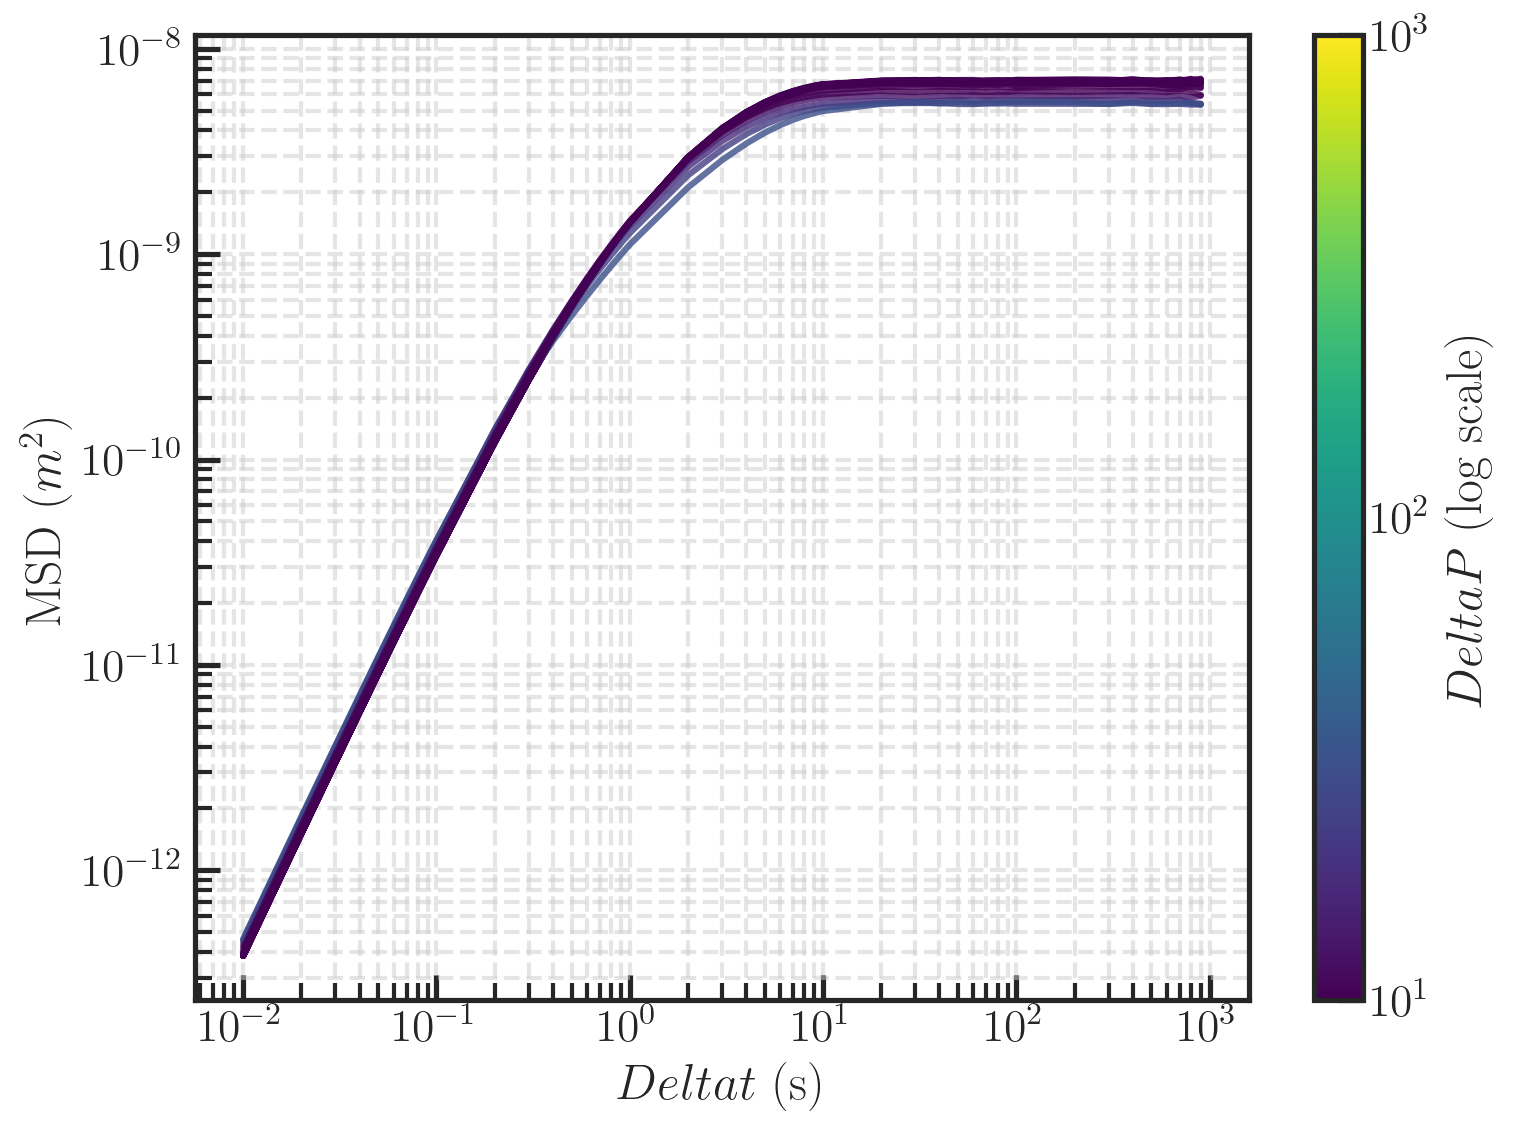

In [135]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import re

def extract_delta_p(name):
    match = re.search(r"delta_P_([0-9.eE+-]+)", name)
    if match:
        delta_p_str = match.group(1).rstrip('-')
        try:
            return float(delta_p_str)
        except ValueError:
            print(f"Could not convert '{delta_p_str}' to float.")
    return None

def extract_T(name):
    match = re.search(r"(?<!kb)T_([0-9.eE+-]+)", name)
    if match:
        T_str = match.group(1).rstrip('-')
        try:
            return float(T_str)
        except ValueError:
            print(f"Could not convert '{T_str}' to float.")
    return None


fig, ax = plt.subplots(figsize=(8, 6))
results_root = Path("./Results/Brady_plot")

csv_paths = sorted(results_root.glob("*/MSD.csv"))
print(f"Found {len(csv_paths)} MSD files.")


vmin, vmax = 10, 1e3 # messed up the min max thing. put it by hand for now.
log_norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
cmap = cm.viridis

for csv_path in csv_paths:
    print(csv_path)
    df = pd.read_csv(csv_path)
    t = df["t"]
    # msd = df["msdxhat"]
    msd_drift = df["msdy"]

    delta_p = extract_delta_p(csv_path.parent.name)
    T = extract_T(csv_path.parent.name)

    if delta_p is None or T is None:
        continue

    print(f"Plotting data for Delta P = {delta_p:.2e}")
    color = cmap(log_norm(delta_p))
    label = f"$\\Delta P = {delta_p:.0f}$"

    if T == 2:
        # ax.loglog(t, msd, label=label, color=color, alpha=0.8)
        ax.loglog(t, msd_drift, label=label, color=color, alpha=0.8)

# Add colorbar (thanks chatgpt)
sm = cm.ScalarMappable(cmap=cmap, norm=log_norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label=r"$\\Delta P$ (log scale)")

ax.set_xlabel(r"$\\Delta t$ (s)")
ax.set_ylabel("MSD ($m^2$)")
ax.grid(True, which="both", linestyle="--", alpha=0.5)


plt.savefig("xhat_MSD_comparison_deltaPlog.pdf", transparent=True)
plt.tight_layout()
plt.show()

<>:289: SyntaxWarning: invalid escape sequence '\m'
<>:294: SyntaxWarning: invalid escape sequence '\m'
<>:289: SyntaxWarning: invalid escape sequence '\m'
<>:294: SyntaxWarning: invalid escape sequence '\m'
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_9345/75871727.py:289: SyntaxWarning: invalid escape sequence '\m'
  label=f"$\\alpha_\mathrm{{fit}}= {b_fit:.4f}$")
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_9345/75871727.py:294: SyntaxWarning: invalid escape sequence '\m'
  plt.loglog(pe_line, 1 + 1/210 * pe_line , '--', color='k', label="$\\alpha_\mathrm{{theo}} = 1/210$", zorder = 5)


Found 217 MSD files.


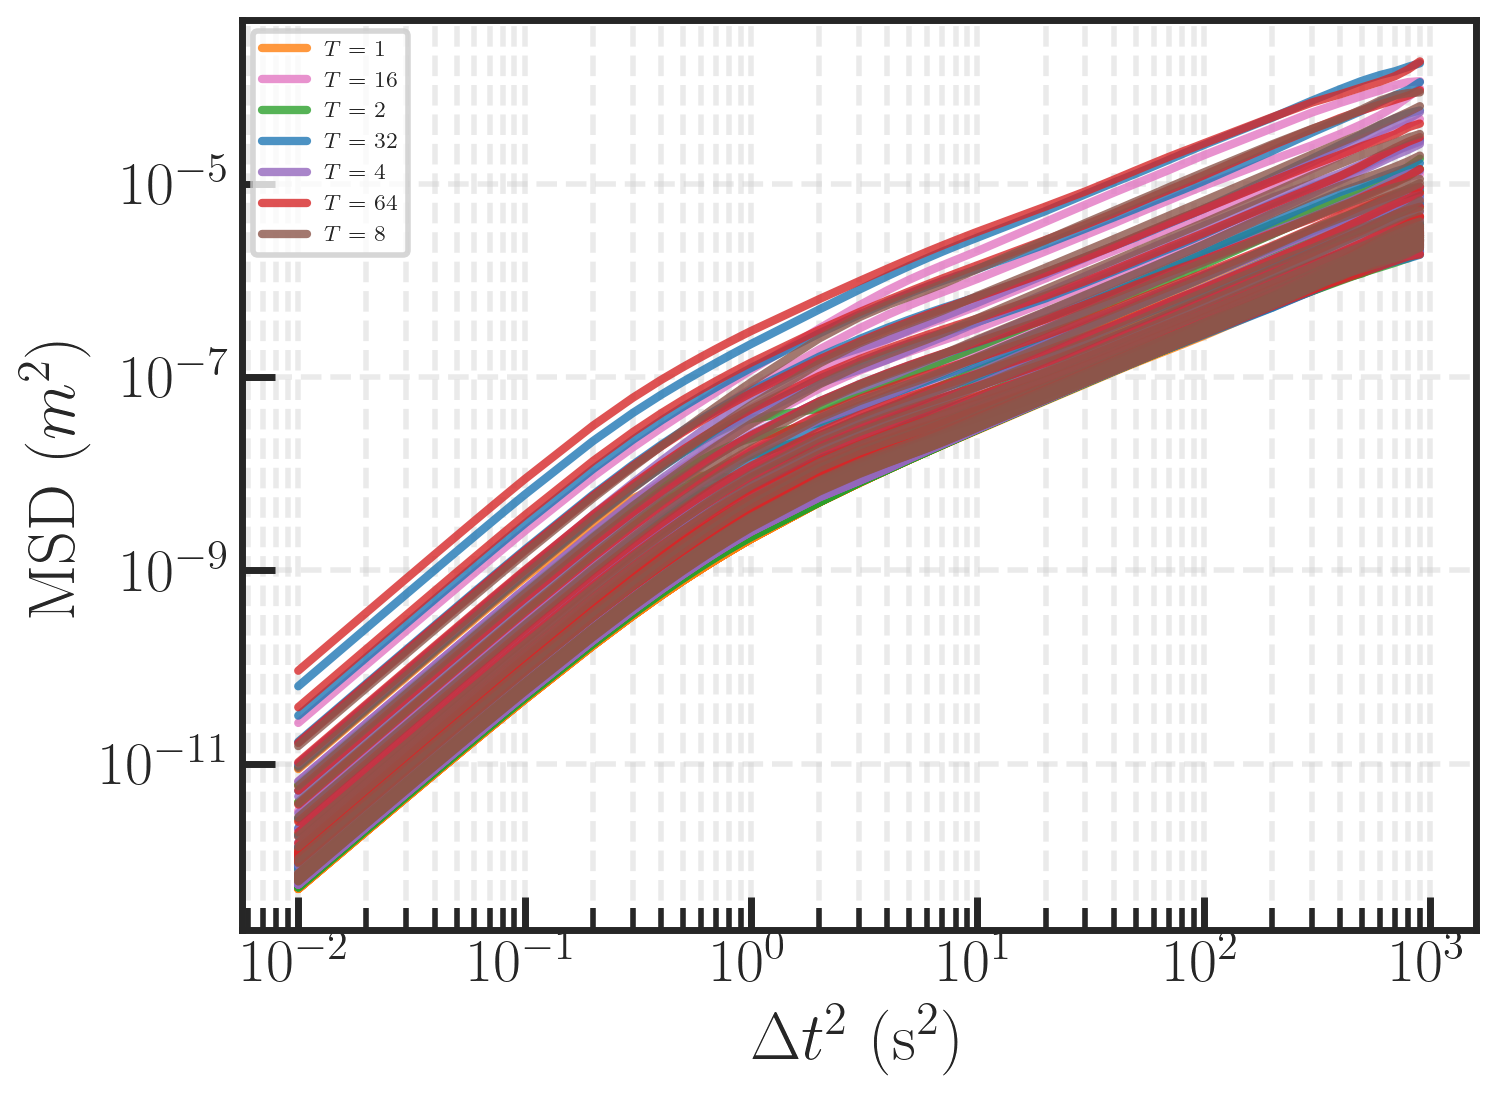

/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_9345/75871727.py:189: RuntimeWarning: invalid value encountered in divide
  self.alpha_values = (self.intercept_Deff / self.D0_values_all - 1) / (self.peclet_values ** 2)
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_9345/75871727.py:226: RuntimeWarning: invalid value encountered in log10
  return np.log10(1 + b * pesq)


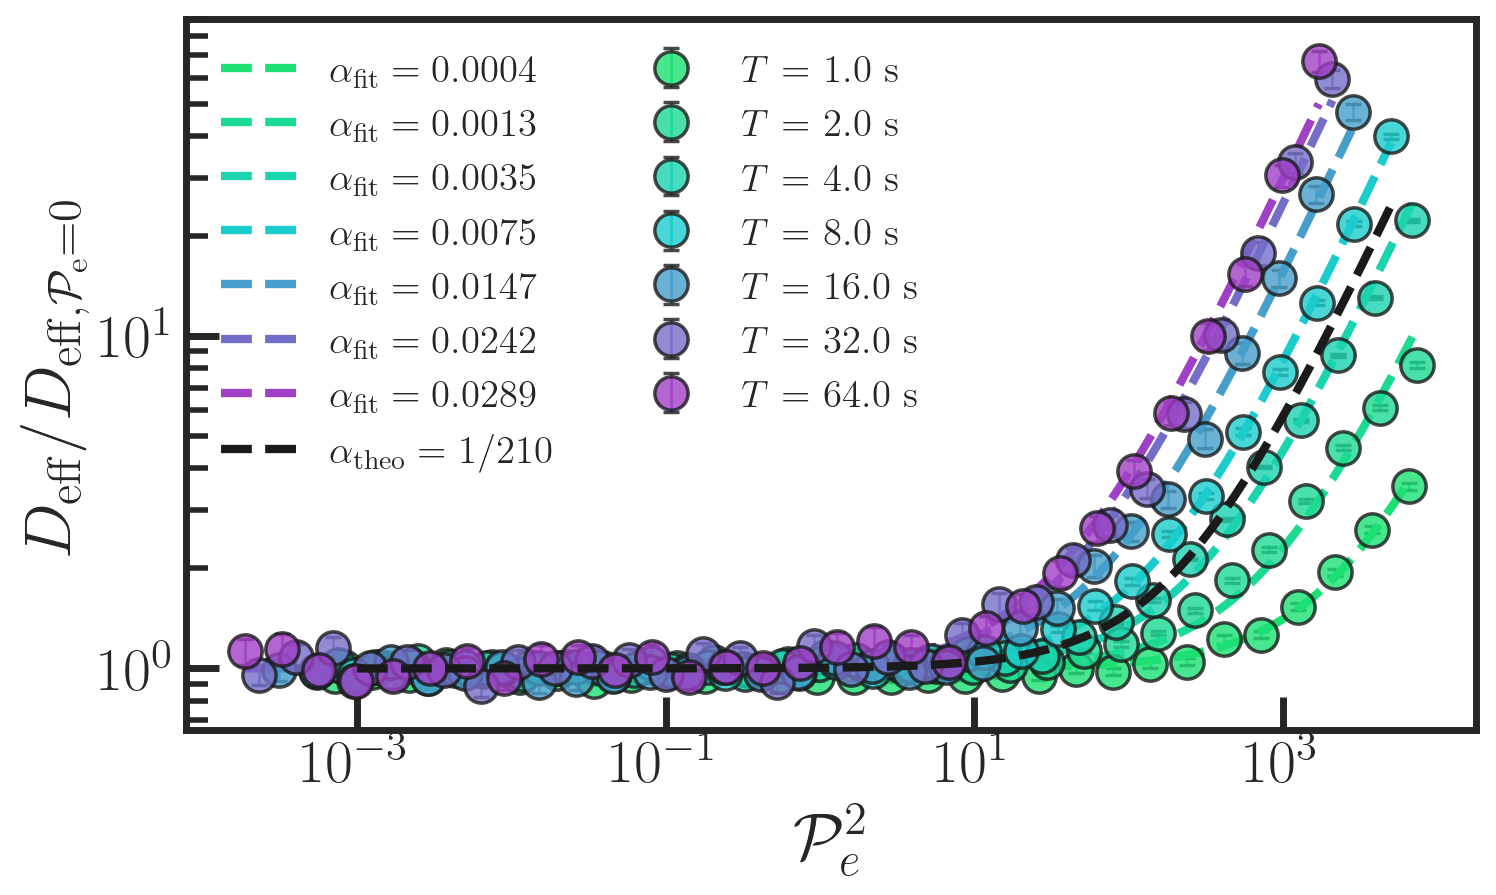

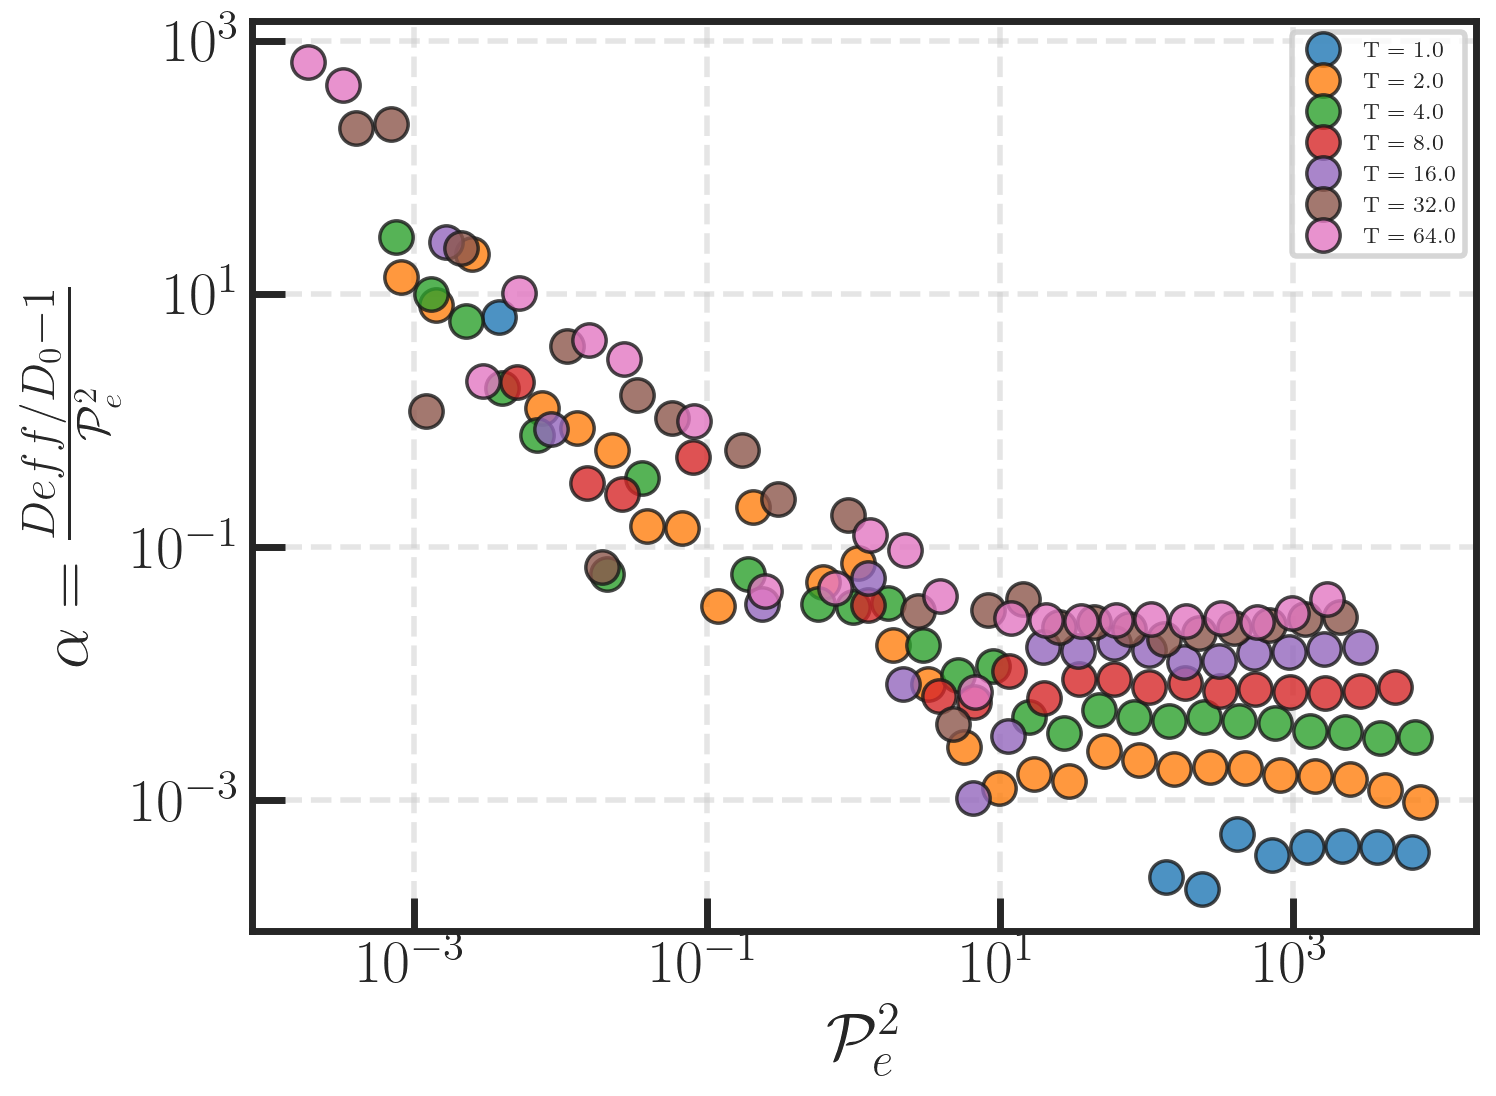

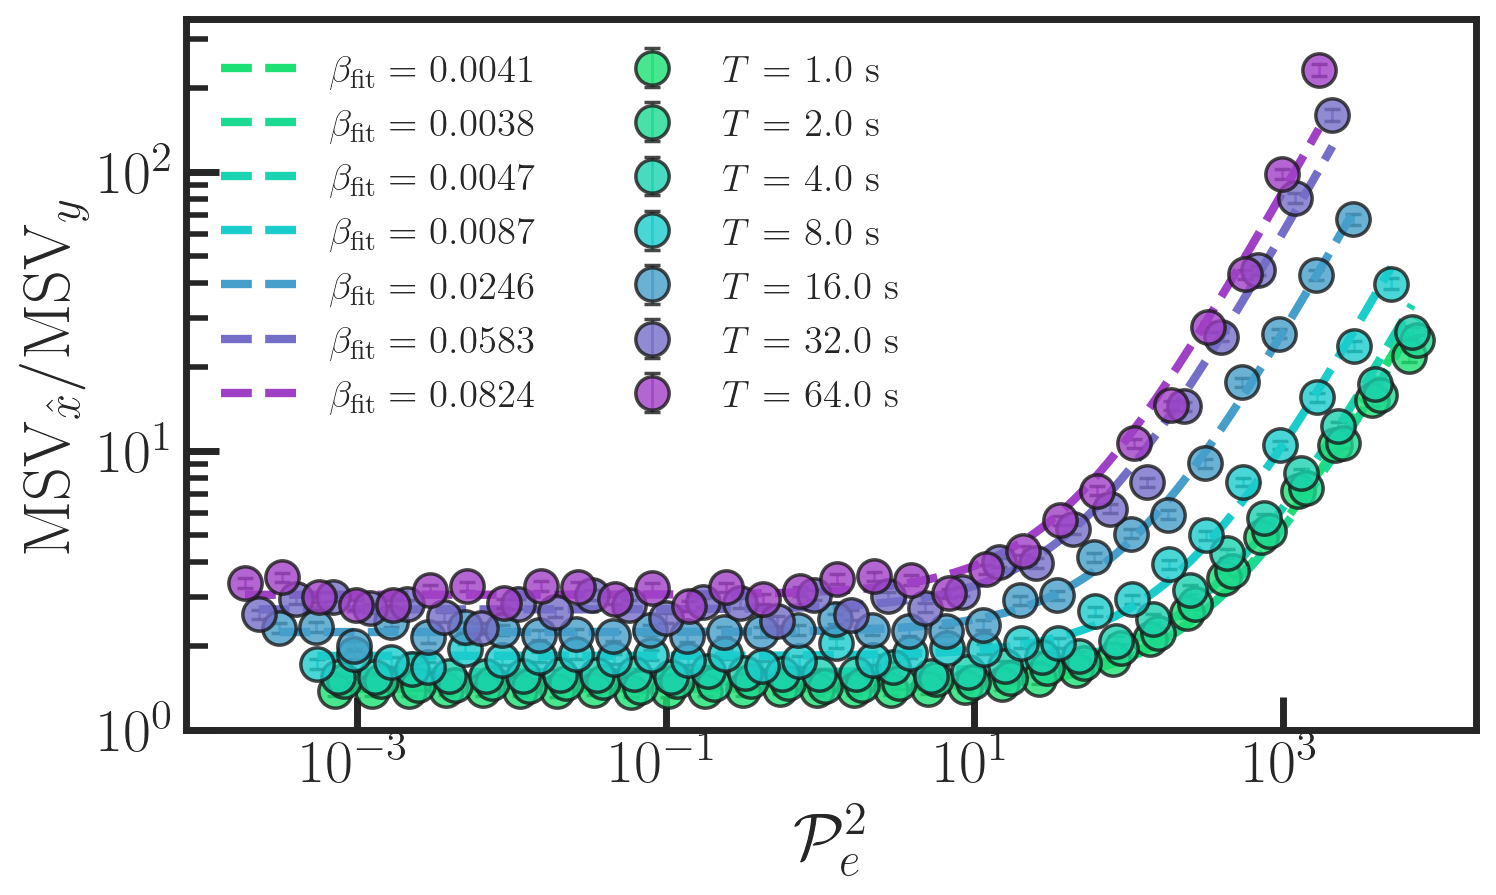

Alpha values: [ 2.81000617e+01  6.08964800e-02  3.52518433e-03 -3.96610486e-01
  1.05829575e-02  1.67313328e-02 -3.51735124e-02  8.56874397e-01
  3.97245531e-03  4.26739143e-03 -3.02578456e+01  3.19282056e-03
  1.77997958e-03 -5.90632940e+00 -6.40667518e+00 -7.22711873e+00
  1.47811991e-02  3.61267796e-02  2.46460327e-04  2.03892601e+00
  1.68544343e-02  2.58975144e+01 -8.49273543e-01 -4.55313539e+01
  2.64499116e-01  2.11045789e-02 -1.90121602e+01  4.56790883e-03
  2.09102687e-03             nan  2.33273483e-02  3.66163794e-04
  1.41674550e-03  5.13205319e-01  9.97267758e-01  5.89021333e-01
 -1.83310013e+01  4.09395927e-02 -2.35288671e-01 -6.07349385e-02
  7.56694537e-03 -6.80653914e+01 -2.69546581e-01 -2.17543679e+01
 -1.03570636e+00 -2.04978072e+01  1.16032012e-02  4.36807247e+00
  4.19932155e-03 -2.61722400e+00  2.08910538e-01 -8.94810643e-02
  1.36876097e+01  1.19312235e+00 -6.19848729e-03 -1.09383429e+00
 -1.27493948e-01  1.25713447e-03  3.04049920e+00  1.23924571e-01
  2.3799387

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import re
import csv
from pathlib import Path
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap


class BradyFullAnalysis:
    def __init__(self, results_root):
        self.results_root = Path(results_root)
        self.csv_paths = sorted(self.results_root.glob("*/MSD.csv"))
        self.T_values_all = [self.extract_T(p.parent.name) for p in self.csv_paths]
        self.deltap_values_all = [self.extract_delta_p(p.parent.name) for p in self.csv_paths]
        self.T_values_set = set(filter(None, self.T_values_all))
        self.T_to_color = {T: cm.tab10.colors[i % 10] for i, T in enumerate(self.T_values_set)}

        self.intercepts_x = []
        self.stdintercepts_x = []
        self.intercepts_y = []
        self.stdintercepts_y = []
        self.pressures = []
        self.T_list = []
        self.data_records = []

    @staticmethod
    def extract_T(name):
        match = re.search(r"(?<!kb)T_([0-9.eE+-]+)", name)
        return float(match.group(1).rstrip('-')) if match else None

    @staticmethod
    def extract_delta_p(name):
        match = re.search(r"delta_P_([0-9.eE+-]+)", name)
        return float(match.group(1).rstrip('-')) if match else None

    def D0_from_T_single(self, T): 
        return {
            1.0: 1.4509460868957787e-09,
            2.0: 1.3633762707901412e-09, 
            4.0: 1.4202708043410992e-09,
            8.0: 1.6583595701294436e-09, 
            16.0: 2.198442940667387e-09, 
            32.0: 2.5690240231651334e-09,
            64.0 : 2.8429810872611832e-09,
            128.0 : 2.8521020173536553e-09,
        }.get(T, np.nan)
    
    def stdD0_from_T_single(self, T): 
        return {
            1.0: 1.7086393487229564e-11, 
            2.0: 9.290666352880448e-12, 
            4.0: 3.344351199402897e-12, 
            8.0: 1.2332039601613544e-11, 
            16.0: 6.221357699145525e-11, 
            32.0: 8.032121913692217e-11,
            64.0 : 9.700257949673962e-11,
            128.0 : 8.241080621528503e-11
        }.get(T, np.nan)

    def D0_from_T(self, T_list):
        return np.array([self.D0_from_T_single(T) for T in T_list])
    
    def stdD0_from_T(self, T_list):
        return np.array([self.stdD0_from_T_single(T) for T in T_list])

    def Peclet_number_calculator(self, delta_ps, D0s):
        W = 180e-6
        L = 88e-3
        eta_0 = 1e-3
        u0 = 1 / (2 * eta_0) * delta_ps / L * (W/2) ** 2 
        return (u0) * W / (D0s) * 2/3 * 1/np.sqrt(2) 
    
    

    def collect_MSD_intercepts(self):
        fig, ax = plt.subplots(figsize=(8, 6))
        T_plotted = set()

        for csv_path in self.csv_paths:
            df = pd.read_csv(csv_path)
            t = df["t"].values
            msd_x = df["msdxhat"].values
            msd_y = df["msdy"].values

            folder = csv_path.parent.name
            T = self.extract_T(folder)
            delta_p = self.extract_delta_p(folder)
            if T is None or delta_p is None:
                continue

            color = self.T_to_color[T]
            label = f"$T$ = {T:.2g}" if T not in T_plotted else None
            ax.loglog(t, msd_x, label=label, color=color, alpha=0.8)
            T_plotted.add(T)

            mask = t <= 0.1
            if np.sum(mask) >= 2:
                log_t = np.log10(t[mask])
                norm_msd_x = msd_x[mask] / t[mask]**2
                norm_msd_y = msd_y[mask] / t[mask]**2

                # X direction
                coeffs_x, cov_x = np.polyfit(log_t, np.log10(norm_msd_x), 1, cov=True)
                intercept_log_x = coeffs_x[1]
                intercept_x = 10 ** intercept_log_x
                std_log_x = np.sqrt(cov_x[1, 1])
                std_intercept_x = np.log(10) * intercept_x * std_log_x

                # Y direction
                coeffs_y, cov_y = np.polyfit(log_t, np.log10(norm_msd_y), 1, cov=True)
                intercept_log_y = coeffs_y[1]
                intercept_y = 10 ** intercept_log_y
                std_log_y = np.sqrt(cov_y[1, 1])
                std_intercept_y = np.log(10) * intercept_y * std_log_y

                self.intercepts_x.append(intercept_x)
                self.stdintercepts_x.append(std_intercept_x)
                self.intercepts_y.append(intercept_y)
                self.stdintercepts_y.append(std_intercept_y)

                self.pressures.append(delta_p)
                self.T_list.append(T)


        ax.set_xlabel(r"$\Delta t^2$ (s$^2$)")
        ax.set_ylabel("MSD ($m^2$)")
        ax.grid(True, which="both", linestyle="--", alpha=0.4)
        ax.legend(fontsize=8)
        plt.tight_layout()
        plt.savefig(self.results_root / "xhat_MSD_vs_t_squared_by_T.pdf", transparent=True)
        plt.show()




    def extract_Deff_from_csv(self, csv_path, comp):
        results = []
        with open(csv_path, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                if row['Component'] == comp and row['Deff'] and row['stdDeff']:
                    try:
                        Deff = float(row['Deff'])
                        stdDeff = float(row['stdDeff'])
                        results.append((Deff, stdDeff))
                    except ValueError:
                        continue
        return results


    def collect_Deff_data(self, comp):
        self.data_records.clear()

        for subdir in self.results_root.iterdir():
            if not subdir.is_dir():
                continue
            csv_path = subdir / "fit_results.csv"
            if not csv_path.exists():
                continue

            T = self.extract_T(subdir.name)
            delta_p = self.extract_delta_p(subdir.name)
            if T is None or delta_p is None:
                continue

            for Deff, stdDeff in self.extract_Deff_from_csv(csv_path, comp):
                if not np.isnan(Deff):
                    self.data_records.append({
                        "T": T,
                        "delta_p": delta_p,
                        "Deff": Deff,
                        "stdDeff": stdDeff,
                        "D0": self.D0_from_T_single(T),
                        "stdD0": self.stdD0_from_T_single(T),
                    })

        self.T_for_Deff = np.array([r["T"] for r in self.data_records])
        self.delta_p_values = np.array([r["delta_p"] for r in self.data_records])
        self.intercept_Deff = np.array([r["Deff"] for r in self.data_records])
        self.stdDeff = np.array([r["stdDeff"] for r in self.data_records])
        self.D0_values_all = np.array([r["D0"] for r in self.data_records])
        self.stdD0_values_all = np.array([r["stdD0"] for r in self.data_records])

        self.peclet_values = self.Peclet_number_calculator(self.delta_p_values, self.D0_values_all)
        self.alpha_values = (self.intercept_Deff / self.D0_values_all - 1) / (self.peclet_values ** 2)





    def plot_Deff(self):
        plt.figure(figsize=(8, 6))
        for T in sorted(set(self.T_for_Deff)):
            idx = self.T_for_Deff == T
            plt.errorbar(
                self.peclet_values[idx],
                self.intercept_Deff[idx],
                yerr=1.96 * self.stdDeff[idx],
                fmt='o',
                label=f"T = {T}",
                alpha=0.8,
                capsize=3,
                color=self.T_to_color.get(T, "gray")
            )
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel(r"$\mathcal{P}_e$")
        plt.ylabel("Deff")
        plt.grid(True, which="both", linestyle="--", alpha=0.2)
        plt.legend()
        plt.tight_layout()
        plt.savefig(self.results_root / "D.pdf", transparent=True)
        plt.show()


    



    def plot_Deff_over_D0_by_T_fit(self):
        def model_log_deff(pesq, b):
            return np.log10(1 + b * pesq)

        plt.figure(figsize=(8, 5))
        results = []
        dfs_D = []

        one = "#1CE074"
        two = "#19CDCC"
        three = "#A040C6"
        cmap = LinearSegmentedColormap.from_list("custom_red_cyan", [one, two, three])

        unique_Ts = sorted(set(self.T_for_Deff))
        n_colors = len(unique_Ts)
        custom_colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]

        for i, T in enumerate(unique_Ts):
            idx = self.T_for_Deff == T
            Pe2 = self.peclet_values[idx] ** 2

            Dx = self.intercept_Deff[idx]
            stdDx = self.stdDeff[idx]
            D0 = self.D0_values_all[idx]
            stdD0 = self.stdD0_values_all[idx] 

            Dx_D0 = Dx / D0
            stdDx_D0 = Dx_D0 * np.sqrt((stdDx / Dx) ** 2 + (stdD0 / D0) ** 2) * 1.96

            df = pd.DataFrame({
                f"Pe^2 (T={T})": Pe2,
                f"Dx/D0 (T={T})": Dx_D0,
                f"std Dx_D0 (T={T})": stdDx_D0
            })
            dfs_D.append(df.reset_index(drop=True))

            mask = np.isfinite(Pe2) & np.isfinite(Dx_D0) & (Pe2 > 0) & (Dx_D0 > 0)
            if np.sum(mask) < 2:
                continue

            try:
                popt, pcov = curve_fit(model_log_deff, Pe2[mask], np.log10(Dx_D0[mask]))
                b_fit = popt[0]
                b_std = np.sqrt(pcov[0, 0])
            except Exception as e:
                print(f"Fit failed for T={T}: {e}")
                continue

            results.append({"T": T, "alpha": b_fit, "alpha_std": b_std})

            pesq_fit = np.logspace(np.log10(min(Pe2[mask])), np.log10(max(Pe2[mask])), 500)
            fit_vals = 10 ** model_log_deff(pesq_fit, b_fit)

            color = custom_colors[i]

            plt.errorbar(
                Pe2[mask], Dx_D0[mask],
                yerr=stdDx_D0[mask],
                fmt='o',
                color=color,
                capsize=3,
                elinewidth=1,
                label=f"$T$ = {T} s", alpha=0.8
            )
            plt.loglog(pesq_fit, fit_vals, '--', color=color,
                       label=f"$\\alpha_\mathrm{{fit}}= {b_fit:.4f}$")

        pd.concat(dfs_D, axis=1).to_csv(self.results_root / "Dx_D0_ratio_vs_Pe2_per_period.csv", index=False)

        pe_line = np.linspace(.001, 5000, 50000)
        plt.loglog(pe_line, 1 + 1/210 * pe_line , '--', color='k', label="$\\alpha_\mathrm{{theo}} = 1/210$", zorder = 5)
        plt.xlabel(r"$\mathcal{P}_e^2$")
        plt.ylabel(r"$D_\mathrm{eff} / D_\mathrm{eff, \mathcal{P}_e = 0}$")
        plt.legend(fontsize=14, ncols=2, frameon=False)
        plt.tight_layout()
        plt.savefig(self.results_root / "DxD0_vs_Pe2_by_T_fits.pdf", transparent=True)
        plt.show()
        pd.DataFrame(results).to_csv(self.results_root / "alpha_vs_T_fit_results.csv", index=False)





    def plot_Vratiosq_vs_Pesq_fit(self):
        def model_ratio_log(pe2, a, beta):
            return np.log10(a + beta * pe2)

        plt.figure(figsize=(8, 5))
        results = []
        dfs_v = []

        one = "#1CE074"
        two = "#19CDCC"
        three = "#A040C6"
        cmap = LinearSegmentedColormap.from_list("custom_red_cyan", [one, two, three])

        unique_Ts = sorted(set(self.T_list))
        n_colors = len(unique_Ts)
        custom_colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]

        for i, T in enumerate(unique_Ts):
            idx = np.array(self.T_list) == T

            Pe2 = np.array(self.Peclet_number_calculator(
                np.array(self.pressures)[idx],
                self.D0_from_T(np.array(self.T_list)[idx])
            )) ** 2

            Vx2 = np.array(self.intercepts_x)[idx]
            Vy2 = np.array(self.intercepts_y)[idx]
            std_Vx2 = np.array(self.stdintercepts_x)[idx]
            std_Vy2 = np.array(self.stdintercepts_y)[idx]

            ratio = Vx2 / Vy2
            std_ratio = ratio * np.sqrt((std_Vx2 / Vx2) ** 2 + (std_Vy2 / Vy2) ** 2) * 1.96

            df = pd.DataFrame({
                f"Pe^2 (T={T})": Pe2,
                f"Vx^2/Vy^2 (T={T})": ratio,
                f"std Vx^2/Vy^2 (T={T})": std_ratio
            })
            dfs_v.append(df.reset_index(drop=True))

            mask = np.isfinite(Pe2) & np.isfinite(ratio) & (Pe2 > 0) & (ratio > 0)
            if np.sum(mask) < 2:
                continue

            try:
                log_ratio = np.log10(ratio[mask])
                popt, pcov = curve_fit(model_ratio_log, Pe2[mask], log_ratio, bounds=(0, np.inf))
                a_fit, beta_fit = popt
                a_std, beta_std = np.sqrt(np.diag(pcov))
            except Exception as e:
                print(f"Fit failed for T={T}: {e}")
                continue

            results.append({"T": T, "beta": beta_fit, "beta_std": beta_std})

            pesq_fit = np.logspace(np.log10(min(Pe2[mask])), np.log10(max(Pe2[mask])), 500)
            fit_vals = 10 ** model_ratio_log(pesq_fit, a_fit, beta_fit)

            color = custom_colors[i]

            plt.errorbar(
                Pe2[mask], ratio[mask],
                yerr=std_ratio[mask],
                fmt='o',
                color=color,
                capsize=3,
                elinewidth=1,
                label=f"$T$ = {T} s", alpha=0.8
            )
            plt.loglog(pesq_fit, fit_vals, '--', color=color,
                       label=f"$\\beta_\\mathrm{{fit}} = {beta_fit:.4f}$")

        pd.concat(dfs_v, axis=1).to_csv(self.results_root / "Vx2_Vy2_ratio_vs_Pe2_per_period.csv", index=False)

        plt.xlabel(r"$\mathcal{P}_e^2$")
        plt.ylabel(r"$\mathrm{MSV}_{\hat{x}}/\mathrm{MSV}_y$")
        plt.legend(fontsize=14, ncols=2, frameon=False)
        plt.ylim(1, None)
        plt.tight_layout()
        plt.savefig(self.results_root / "Vx2Vy2_vs_Pe2_by_T_fits.pdf", transparent=True)
        plt.show()
        pd.DataFrame(results).to_csv(self.results_root / "beta_vs_T_fit_results.csv", index=False)






    def plot_alpha_vs_Pe2(self):
        plt.figure(figsize=(8, 6))
        for i, T in enumerate(sorted(set(self.T_for_Deff))):
            idx = self.T_for_Deff == T
            plt.loglog(self.peclet_values[idx] ** 2, self.alpha_values[idx],
                       'o', label=f"T = {T}", color=cm.tab10.colors[i % 10], alpha=0.8)
        plt.xlabel(r"$\mathcal{P}_e^2$")
        plt.ylabel(r"$\alpha = \frac{Deff/D_0 - 1}{\mathcal{P}_e^2}$")
        plt.grid(True, which="both", linestyle="--", alpha=0.5)
        plt.legend(fontsize = 8)
        plt.tight_layout()
        plt.savefig(self.results_root / "alpha_vs_Pe2_by_T.pdf", transparent=True)
        plt.show()


# ==== please work gods pleas e work please ====
results_root = "./Results/Brady_plot"
brady = BradyFullAnalysis(results_root)

print(f"Found {len(brady.csv_paths)} MSD files.")
brady.collect_MSD_intercepts()

brady.collect_Deff_data("msdxhat")
# brady.plot_Deff()
brady.plot_Deff_over_D0_by_T_fit()
brady.plot_alpha_vs_Pe2()
brady.plot_Vratiosq_vs_Pesq_fit()

print("Alpha values:", brady.alpha_values)
print("mean alpha:", np.mean(np.ma.masked_invalid(brady.alpha_values)))
print("std alpha:", np.std(np.ma.masked_invalid(brady.alpha_values)))




# Peq de y

yall = np.linspace(0, 10, 1000)

normalized_bins=[(0, 0.125), (0.125, 0.25), (0.25, 0.375), (0.375, 0.5),
                                                         (0.5, 0.625), (0.625, 0.75), (0.75, 0.875), (0.875, 1.0)]
real_bins = np.asarray(normalized_bins) * 10.

for bin in real_bins :
    print(min(bin))
# for y in yall :
#     for bin in real_bins :
#                 if min(np.asarray(bin)) <= y < max(np.asarray(bin)) :
#                     times[bin] += 1e-3
        
#         print(times)
#         return (times)

print(np.asarray(real_bins))

## Test over 1 file
base = "N_1000000-tau_0.001-R_5e-06-H_0.00018-eta_0_0.001-kbT_4.141947e-21-D_r_0.5-v_0.0001-T_1.0-delta_P_14.400000000000027-L_0.18-oscillations_True-N_trajectories_10-Job_ID_10_0" #Data file name. No extension here.
extension = ".pickle" # Data file extension.
case_study = "Brady_plot/" # Enter subdir of the study you are doing.

save_path, picklefile = path_function(base = base, extension = extension, case_study = case_study)


analyzer_PDF = PDFcalculator_saver(picklefile, save_path, L = 88e-3, H = 170e-6, bins_per_dim=31)
analyzer_PDF.plot_all_average_PDF(save_path)
analyzer_PDF.save_PDF_to_csv(save_path)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
import pandas as pd
import os

class PDFcalculator_saver:
    def __init__(self, pickle_path, save_dir="./Results/test/", L=88e-3, H=170e-6, bins_per_dim=31):
        self._load_pickle(pickle_path)

        self.L = L  # Length of system in x
        self.H = H  # Height of system in y
        self.bins_per_dim = bins_per_dim

        # Define fixed bin edges
        self.bin_edges = {
            'x': np.linspace(-L, L, bins_per_dim + 1),
            'y': np.linspace(0, H, bins_per_dim + 1),
            'phi': np.linspace(0, 2*np.pi, bins_per_dim + 1)
        }

    def _load_pickle(self, path):
        with open(path, "rb") as f:
            data = pickle.load(f)

        self.raw_data = data
        self.tau = data["tau"]
        self.num_trajectories = data["N_trajectories"]

        self.x_all = [np.array(data[f"x_{i}"]) for i in range(self.num_trajectories)]
        self.y_all = [np.array(data[f"y_{i}"]) for i in range(self.num_trajectories)]
        self.phi_all = [
            np.array(data.get(f"phi_{i}", np.zeros_like(self.x_all[i])) % (2 * np.pi))
            for i in range(self.num_trajectories)
        ]
        self.t = np.array(data["t"])

    def compute_average_PDF(self, signal_list, comp_name):
        all_pdf = []
        for signal in signal_list:
            PDF_vals, bin_centers = self.compute_PDF(signal, bins=self.bin_edges[comp_name])
            all_pdf.append(PDF_vals)

        all_pdf = np.array(all_pdf)
        pdf_avg = np.nanmean(all_pdf, axis=0)
        pdf_std = np.nanstd(all_pdf, axis=0)
        return pdf_avg, pdf_std, bin_centers

    def compute_PDF(self, comp, bins=None, density=True):
        if bins is None:
            bins = 100
        pdf_comp, bins_edge_comp = np.histogram(comp, bins=bins, density=density)
        bins_center_comp = (bins_edge_comp[:-1] + bins_edge_comp[1:]) / 2
        return pdf_comp, bins_center_comp

    def compute_all_average_PDF(self):
        self.PDF_data = {}
        for comp in ['x', 'y', 'phi']:
            signal_list = getattr(self, f"{comp}_all")
            avg, std, scales = self.compute_average_PDF(signal_list, comp)
            self.PDF_data[comp] = {'scales': scales, 'avg': avg, 'std': std}

    def compute_area_in_bins_y(self, normalized_bins=[(0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1.0)]):
        """
        Compute the area under the PDF(y) curve for specified normalized bins and return results scaled by H.
        """
        data = self.PDF_data['y']
        y_vals = data['scales']
        pdf_vals = data['avg']

        areas = []
        for a, b in normalized_bins:
            lower = a * self.H
            upper = b * self.H
            mask = (y_vals >= lower) & (y_vals < upper)
            area = np.trapz(pdf_vals[mask], y_vals[mask])
            scaled_area = area * self.H
            areas.append((f"{a:.2f}-{b:.2f}", scaled_area))
        return areas

    def plot_all_average_PDF(self, save_path=None, show=True):
        if not hasattr(self, 'PDF_data'):
            self.compute_all_average_PDF()

        fig, axes = plt.subplots(1, 3, figsize=(12, 6))
        fig.tight_layout(pad=4.0)
        titles = ['$x$ component', '$y$ component', '$\phi$ (orientation)']

        for ax, comp, title in zip(axes.flat[:3], ['x', 'y', 'phi'], titles[:3]):
            data = self.PDF_data[comp]

            if comp == "y":
                ax.vlines([0, self.H], -2000, 70000, colors='k', alpha=0.7, linewidth=5)

                # Annotate areas in y bins
                areas = self.compute_area_in_bins_y()
                for i, (label, val) in enumerate(areas):
                    xpos = (i + 0.5) * self.H / 4
                    ax.text(xpos, max(data['avg']) * 0.8, f"{val:.2e}", ha='center', fontsize=10, rotation=90)

            ax.semilogy(data['scales'], data['avg'], label=f"PDF (${comp}$)", color='#55C4FF', marker='o', markersize=5)
            ax.fill_between(data['scales'], data['avg'] - data['std'], data['avg'] + data['std'],
                            color='#7BDFFF', alpha=0.3)
            ax.set_title(title)
            ax.set_xlabel(f"${comp}$ (m)") if comp != "phi" else ax.set_xlabel("$\\phi$ (rad)")
            ax.set_ylabel("PDF ($m^{-1}$)" if comp != "phi" else "PDF ($rad^{-1}$)")
            ax.grid(True, which="both", linestyle="--", alpha=0.5)

        if save_path:
            save_path = Path(save_path)
            filename = f"{save_path}/PDF_plot.pdf"
            plt.savefig(filename, transparent=True, bbox_inches="tight")
            print(f"Plot saved to: {filename}")

        if show:
            plt.show()

        plt.close()

    def save_PDF_to_csv(self, save_path):
        if not hasattr(self, 'PDF_data'):
            self.compute_all_average_PDF()

        data = self.PDF_data
        df = pd.DataFrame({
            "pdfx": data['x']['avg'],
            "stdx": data['x']['std'],
            "pdfy": data['y']['avg'],
            "stdy": data['y']['std'],
            "pdfphi": data['phi']['avg'],
            "stdphi": data['phi']['std']
        })

        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        save_path_csv = str(save_path) + "/PDF.csv"
        df.to_csv(save_path_csv, index=False)
        print(f"PDF CSV saved to: {save_path}")


    def time_per_slice_of_y(self, normalized_bins=[(0, 0.125), (0.125, 0.25), (0.25, 0.375), (0.375, 0.5),
                                               (0.5, 0.625), (0.625, 0.75), (0.75, 0.875), (0.875, 1.0)]):

        real_bins = np.asarray(normalized_bins) * self.H
        times = {tuple(bin): 0 for bin in real_bins}
    
        for y in self.y_all[0]:
            for bin in real_bins:
                if np.min(bin) <= y < np.max(bin):
                    times[tuple(bin)] += 1e-3  # Increment time in seconds
    
        # Plotting
        bin_labels = [f"{b[0]*1e6:.0f}-{b[1]*1e6:.0f} µm" for b in real_bins]  # Micrometer range labels
        time_values = list(times.values())
    
        plt.figure(figsize=(10, 5))
        bars = plt.bar(bin_labels, time_values, color='skyblue', edgecolor='black')
        plt.xlabel("Y Slice Range (µm)")
        plt.ylabel("Time Spent (s)")
        plt.title("Time Spent Per Y Slice")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
    
        # Add values on top of bars
        for bar, value in zip(bars, time_values):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, f"{value:.2f}", 
                     ha='center', va='bottom', fontsize=9)
    
        plt.tight_layout()
        plt.show()
    
        return times
    
    def plot_phi_PDFs_per_yslice(self, save_path=None, show=True):
        """
        Plots the PDFs of φ for each y-slice.
    
        Parameters:
        - save_path (str or Path): Directory to save the figure (optional).
        - show (bool): Whether to display the plot.
        """
        phi_pdfs, phi_bins = self.compute_PDFphi_per_yslice()
    
        num_slices = len(phi_pdfs)
        ncols = 4
        nrows = int(np.ceil(num_slices / ncols))
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3 * nrows), sharex=True, sharey=True)
        axes = axes.flatten()
    
        for i, ((ymin, ymax), pdf) in enumerate(phi_pdfs.items()):
            centers = phi_bins[(ymin, ymax)]
            axes[i].plot(centers, pdf, label=f"$y \\in [{ymin*1e6:.0f}, {ymax*1e6:.0f}]\\ \mu m$")
            axes[i].set_title(f"{ymin*1e6:.0f}–{ymax*1e6:.0f} µm", fontsize=10)
            axes[i].set_xlabel("φ (rad)")
            axes[i].set_ylabel("PDF (rad⁻¹)")
            axes[i].grid(True, linestyle="--", alpha=0.4)
    
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
    
        plt.tight_layout()
    
        if save_path:
            save_path = Path(save_path)
            save_path.mkdir(parents=True, exist_ok=True)
            fig_path = save_path / "phi_PDFs_per_yslice.pdf"
            plt.savefig(fig_path, bbox_inches="tight", transparent=True)
            print(f"φ PDFs per y-slice saved to: {fig_path}")
    
        if show:
            plt.show()
        plt.close()


<>:90: SyntaxWarning: invalid escape sequence '\p'
<>:196: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\p'
<>:196: SyntaxWarning: invalid escape sequence '\m'
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_60942/315639722.py:90: SyntaxWarning: invalid escape sequence '\p'
  titles = ['$x$ component', '$y$ component', '$\phi$ (orientation)']
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_60942/315639722.py:196: SyntaxWarning: invalid escape sequence '\m'
  axes[i].plot(centers, pdf, label=f"$y \\in [{ymin*1e6:.0f}, {ymax*1e6:.0f}]\\ \mu m$")


In [ ]:
import os
from pathlib import Path

# Root

case_study = "Brady_plot"
output_folder = Path(f"./output_file/{case_study}") 

# Loop over all pickle files
for pickle_path in output_folder.glob("*.pickle"):
    base_name = pickle_path.stem
    print(f"Processing: {base_name}")

    # Set paths
    save_path = Path(f"./Results/{case_study}/{base_name}")
    save_path.mkdir(parents=True, exist_ok=True)


    # Compute and save MSDs
    analyzer = PDFcalculator_saver(pickle_path, save_path, L = 88e-3, H = 180e-6, bins_per_dim=31)
    analyzer.plot_all_average_PDF(save_path=save_path)
    analyzer.save_PDF_to_csv(save_path=save_path)
    analyzer.time_per_slice_of_y()
    analyzer.plot_phi_PDFs_per_yslice(save_path = save_path)

## Vxˆ2, Vyˆ2 = f(Peˆ2)